In [ ]:

import gzip, csv, json, re, itertools, random, time
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from sentence_transformers import models, SentenceTransformer, InputExample, losses, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import numpy as np
import matplotlib.pyplot as plt
from accelerate import notebook_launcher

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)
    return p

data_dir        = ensure_dir(Path("data/GSEA/external_gene_data/store!"))
output_dir      = ensure_dir(Path("output/hard_fine_tune_model"))
best_model_dir  = ensure_dir(output_dir / "best_model")
checkpoint_dir = ensure_dir(output_dir / "checkpoints")
output_folder   = ensure_dir(output_dir / "biolinkbert-large-simcse-rat")
train_path = output_dir / "train.jsonl"
val_path   = output_dir / "val.jsonl"

gene_file     = data_dir / "rat_genes_consolidated.txt.gz"
pathway_file  = data_dir / "wikipathways_synonyms_Rattus_norvegicus.gmt.gz"

train_jsonl     = output_dir / "train.jsonl"
val_jsonl       = output_dir / "val.jsonl"
test_jsonl      = output_dir / "test.jsonl"
spearman_json = output_dir / "spearman_values.json"

base_model     = "michiyasunaga/BioLinkBERT-large"
device         = "cuda" if torch.cuda.is_available() else "cpu"
num_gpus       = torch.cuda.device_count()
print(f"Using {num_gpus} GPUs")

batch_size     = 256
epochs         = 100
learning_rate  = 3e-5
warmup_ratio   = 0.1



In [2]:
# Helper to load a cached HF model into a SentenceTransformer
def load_hf_model(model_path: str, device: str = device, max_seq_length: int = 128) -> SentenceTransformer:
    """
    Loads a SentenceTransformer from a local Hugging Face cache directory,
    and prints the underlying Transformer config without falling back to mean-pooling.
    """
    print("Loading model from:", model_path)
    transformer_for_cfg = models.Transformer(model_path, max_seq_length=max_seq_length)
    cfg = transformer_for_cfg.auto_model.config
    print(f"  config.name_or_path={cfg.name_or_path}, revision={getattr(cfg, 'revision', 'main')}")

    transformer = models.Transformer(model_path, max_seq_length=max_seq_length)
    transformer.auto_model.gradient_checkpointing_enable()
    pool = models.Pooling(
        transformer.get_word_embedding_dimension(),
        pooling_mode_mean_tokens=True
    )
    model = SentenceTransformer(modules=[transformer, pool], device=device)
    print("  Model loaded from cache.")
    return model

import gzip, csv, json, re, itertools, random
from pathlib import Path
from difflib import SequenceMatcher

HARD_NEGATIVES = True

def add_pairs(pairs, texts):
    texts = [t.strip() for t in texts if t and str(t).strip()]
    for a, b in itertools.combinations(set(texts), 2):
        pairs.append((a, b, 1))

# Build positive pairs
pos_pairs = []
with gzip.open(gene_file, "rt") as fh:
    rdr = csv.DictReader(fh)
    for row in rdr:
        add_pairs(pos_pairs, [
            row["Gene stable ID"],
            row["Gene name"],
            row["Gene description"]
        ])

bracket_re = re.compile(r"\[([^\]]+)\]")
with gzip.open(pathway_file, "rt") as fh:
    for line in fh:
        if not line.strip():
            continue
        pathway = re.sub(r"\s+", " ", line.split("\t")[0]).strip()
        for grp in bracket_re.findall(line):
            syns = [g.strip() for g in grp.split(",") if g.strip()]
            add_pairs(pos_pairs, syns)
            for s in syns:
                pos_pairs.append((pathway, s, 1))

all_texts = list({t for a, b, _ in pos_pairs for t in (a, b)})
pos_set    = {(a, b) for a, b, _ in pos_pairs}
num_pos    = len(pos_pairs)

# One‐pass negative sampling + hard/easy split (with oversampling) ──

pool_factor = 3
pool_size   = num_pos * pool_factor
orig_neg = set()
while len(orig_neg) < pool_size:
    a, b = random.sample(all_texts, 2)
    if (a, b) in pos_set or (b, a) in pos_set:
        continue
    orig_neg.add((a, b))

def is_hard_negative(a, b, thresh=0.5):
    return SequenceMatcher(None, a, b).ratio() >= thresh

orig_hard = sum(1 for a, b in orig_neg if is_hard_negative(a, b))


hard_list = [(a, b, 0) for a, b in orig_neg if is_hard_negative(a, b)]
easy_list = [(a, b, 0) for a, b in orig_neg if not is_hard_negative(a, b)]

if HARD_NEGATIVES:
    random.shuffle(hard_list)
    neg_pairs = hard_list[:num_pos]
    needed   = num_pos - len(neg_pairs)
    if needed > 0:
        random.shuffle(easy_list)
        neg_pairs += easy_list[:needed]
    total_hard = len([1 for a, b, _ in neg_pairs if is_hard_negative(a, b)])
    total_easy = num_pos - total_hard
else:
    random.shuffle(list(orig_neg))
    neg_pairs = [(a, b, 0) for a, b in list(orig_neg)[:num_pos]]
    total_hard = 0
    total_easy = num_pos

all_pairs = pos_pairs + neg_pairs
uniq = {}
for a, b, label in all_pairs:
    key = tuple(sorted((a, b)))
    if key not in uniq:
        uniq[key] = label
unique_pairs = [(a, b, lbl) for (a, b), lbl in uniq.items()]

random.shuffle(unique_pairs)
N      = len(unique_pairs)
n_test = int(0.1 * N)
n_rem  = N - n_test
n_val  = n_rem // 9
n_train= n_rem - n_val

splits = {
    "test":  unique_pairs[:n_test],
    "val":   unique_pairs[n_test:n_test+n_val],
    "train": unique_pairs[n_test+n_val:]
}

for name, path in [("train", train_jsonl),
                   ("val",   val_jsonl),
                   ("test",  test_jsonl)]:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        for a, b, label in splits[name]:
            json.dump({"text1": a, "text2": b, "label": label}, f, ensure_ascii=False)
            f.write("\n")

print(f"✅ Train={len(splits['train']):,}  Val={len(splits['val']):,}  Test={len(splits['test']):,}")

import json
from pathlib import Path

def load_pairs(path):
    """
    Load all (text1, text2) pairs from a .jsonl file,
    canonicalizing order so (A,B) == (B,A).
    Returns a set of tuple pairs.
    """
    pairs = set()
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            a, b = data["text1"], data["text2"]
            pair = tuple(sorted((a, b)))
            pairs.add(pair)
    return pairs

def report_overlap(s1, s2, name1, name2):
    overlap = s1 & s2
    if overlap:
        print(f"🔴 Overlap between {name1} and {name2}: {len(overlap)} shared pairs")
        for pair in list(overlap)[:10]:
            print("   ", pair)
    else:
        print(f"✅ No overlap between {name1} and {name2}")

def main():
    base = output_dir
    files = {
        "train": base / "train.jsonl",
        "val":   base / "val.jsonl",
        "test":  base / "test.jsonl",
    }

    print("Loading splits…")
    splits = {name: load_pairs(path) for name, path in files.items()}
    for name, s in splits.items():
        print(f"  {name}: {len(s)} unique pairs")

    print("\nChecking overlaps:")
    report_overlap(splits["train"], splits["val"],   "train", "val")
    report_overlap(splits["train"], splits["test"],  "train", "test")
    report_overlap(splits["val"],   splits["test"],  "val",   "test")


if __name__ == "__main__":
    main()


def train_sbert():

    from datasets import Dataset
    from torch.utils.data import DataLoader
    from transformers import EarlyStoppingCallback, TrainerCallback
    from sentence_transformers import (
        models, SentenceTransformer, InputExample, losses,
        SentenceTransformerTrainer, SentenceTransformerTrainingArguments,
    )
    from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

    random.seed(42); torch.manual_seed(42)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cuda.enable_flash_sdp(True)
    torch.backends.cudnn.benchmark = True

    # ── 0) SBERT architecture ──
    word_model = models.Transformer(base_model, max_seq_length=128)
    word_model.auto_model.gradient_checkpointing_enable()
    pooling = models.Pooling(
        word_model.get_word_embedding_dimension(),
        pooling_mode_mean_tokens=True
    )
    model = SentenceTransformer(modules=[word_model, pooling])

    loss_fn = losses.ContrastiveLoss(model=model, margin=1.0)

    with train_path.open("r", encoding="utf-8") as fh:
        train_examples = [
            InputExample(texts=[d["text1"], d["text2"]], label=d["label"])
            for d in map(json.loads, fh)
        ]
    with val_path.open("r", encoding="utf-8") as fh:
        val_examples = [
            InputExample(texts=[d["text1"], d["text2"]], label=d["label"])
            for d in map(json.loads, fh)
        ]

    train_loader = DataLoader(train_examples, batch_size=batch_size,
                              shuffle=True,  drop_last=True)
    val_loader   = DataLoader(val_examples,   batch_size=batch_size,
                              shuffle=False, drop_last=False)

    train_ds = Dataset.from_list([
        {"text1": ex.texts[0], "text2": ex.texts[1], "label": ex.label}
        for ex in train_examples])
    val_ds   = Dataset.from_list([
        {"text1": ex.texts[0], "text2": ex.texts[1], "label": ex.label}
        for ex in val_examples])

    evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
        val_examples, name="val-eval")


    class SpearmanLogger(TrainerCallback):
        def __init__(self, path: Path):
            self.path = path
            self.history = {"epochs": [], "val_scores": [], "test_scores": []}

        def on_evaluate(self, args, state, control, metrics, **kwargs):
            self.history["epochs"].append(metrics.get("epoch"))
            self.history["val_scores"].append(metrics.get("eval_val-eval_spearman_cosine"))
            self.history["test_scores"].append(metrics.get("eval_test-similarity_cosine") or 0.0)
            self.path.parent.mkdir(parents=True, exist_ok=True)
            self.path.write_text(json.dumps(self.history, indent=2))

    args = SentenceTransformerTrainingArguments(
        output_dir                 = str(checkpoint_dir),
        num_train_epochs           = epochs,
        per_device_train_batch_size= batch_size,
        per_device_eval_batch_size = batch_size,
        learning_rate              = learning_rate,
        warmup_ratio               = warmup_ratio,
        gradient_accumulation_steps= 1,
        fp16                       = True,
        ddp_find_unused_parameters = False,
        eval_strategy              = "steps",
        eval_steps                 = len(train_loader),
        save_strategy              = "steps",
        save_steps                 = len(train_loader),
        load_best_model_at_end     = True,
        metric_for_best_model      = "eval_val-eval_spearman_cosine",
        greater_is_better          = True,
    )

    trainer = SentenceTransformerTrainer(
        model         = model,
        args          = args,
        train_dataset = train_ds,
        eval_dataset  = val_ds,
        loss          = loss_fn,
        evaluator     = evaluator,
        callbacks     = [
            EarlyStoppingCallback(early_stopping_patience=3),
            SpearmanLogger(spearman_json),
        ],
    )

    trainer.train()

    best_model_dir.mkdir(parents=True, exist_ok=True)
    trainer.save_model(str(best_model_dir))

notebook_launcher(train_sbert, num_processes=num_gpus)

In [25]:
base_model = "michiyasunaga/BioLinkBERT-large"

with spearman_json.open("r", encoding="utf-8") as fh:
    history = json.load(fh)

epochs      = history["epochs"]
val_scores  = history["val_scores"]
test_scores = []

with val_jsonl.open("r", encoding="utf-8") as fh:
    val_examples = [
        InputExample(texts=[d["text1"], d["text2"]], label=d["label"])
        for d in map(json.loads, fh)
    ]
evaluator_val = EmbeddingSimilarityEvaluator.from_input_examples(
    val_examples, name="val-eval"
)

with test_jsonl.open("r", encoding="utf-8") as fh:
    test_examples = [
        InputExample(texts=[d["text1"], d["text2"]], label=d["label"])
        for d in map(json.loads, fh)
    ]
evaluator_test = EmbeddingSimilarityEvaluator.from_input_examples(
    test_examples, name="test-eval"
)

print("Evaluating *base* model on VAL & TEST sets …")
base_model_st = load_hf_model(base_model, device=device)

m_val = evaluator_val(base_model_st, output_path=None)
base_val = m_val["val-eval_spearman_cosine"]

m_test = evaluator_test(base_model_st, output_path=None)
base_test = m_test["test-eval_spearman_cosine"]

epochs.insert(0, base_model)
val_scores.insert(0, base_val)
test_scores.insert(0, base_test)

# free memory
del base_model_st, m_val, m_test

checkpoint_dir = output_dir / "checkpoints"
ckpts = sorted(
    [d for d in checkpoint_dir.iterdir()
     if d.is_dir() and d.name.startswith("checkpoint-")],
    key=lambda d: int(d.name.split("-")[1])
)
for ckpt in ckpts:
    print(f"Evaluating {ckpt.name} on TEST set …")
    model_st = load_hf_model(str(ckpt), device=device)
    m_test   = evaluator_test(model_st, output_path=None)
    test_scores.append(m_test["test-eval_spearman_cosine"])
    print(f"  → {ckpt.name}: {test_scores[-1]:.4f}")
    del model_st, m_test

history["epochs"]     = epochs
history["val_scores"] = val_scores
history["test_scores"]= test_scores
spearman_json.write_text(json.dumps(history, indent=2))
print(f"✅  Wrote updated scores to {spearman_json.resolve()}")


Evaluating *base* model on VAL & TEST sets …
Loading model from: michiyasunaga/BioLinkBERT-large
  config.name_or_path=michiyasunaga/BioLinkBERT-large, revision=main
  Model loaded from cache.
Evaluating checkpoint-706 on TEST set …
Loading model from: output/hard_fine_tune_model/checkpoints/checkpoint-706
  config.name_or_path=output/hard_fine_tune_model/checkpoints/checkpoint-706, revision=main
  Model loaded from cache.
  → checkpoint-706: -0.0345
Evaluating checkpoint-1412 on TEST set …
Loading model from: output/hard_fine_tune_model/checkpoints/checkpoint-1412
  config.name_or_path=output/hard_fine_tune_model/checkpoints/checkpoint-1412, revision=main
  Model loaded from cache.
  → checkpoint-1412: 0.3452
Evaluating checkpoint-2118 on TEST set …
Loading model from: output/hard_fine_tune_model/checkpoints/checkpoint-2118
  config.name_or_path=output/hard_fine_tune_model/checkpoints/checkpoint-2118, revision=main
  Model loaded from cache.
  → checkpoint-2118: 0.5399
Evaluating chec

In [19]:
from pathlib import Path
import plotly.graph_objects as go

plot_dir = output_dir / "plots"
plot_dir.mkdir(parents=True, exist_ok=True)

spearman_json = output_dir / "spearman_values.json"
with spearman_json.open("r", encoding="utf-8") as f:
    values = json.load(f)

epochs      = values["epochs"]
val_scores  = values["val_scores"]
test_scores = values["test_scores"]

# Numeric positions and labels
positions = list(range(len(epochs)))
labels = [str(round(e)) if isinstance(e, (int, float)) else str(e) for e in epochs]

fig_val = go.Figure()
fig_val.add_trace(go.Scatter(
    x=positions, y=val_scores, mode="lines+markers", name="Validation"
))
fig_val.update_layout(
    title="Validation Spearman–Cosine over Base Model + epochs",
    xaxis=dict(
        title="Model / Epoch",
        tickmode="array",
        tickvals=positions,
        ticktext=labels,
        tickangle=45
    ),
    yaxis=dict(title="Spearman Cosine", range=[min(val_scores) - 0.02, 1.0])
)
val_path = plot_dir / "spearman_validation.html"
fig_val.write_html(str(val_path), include_plotlyjs="cdn")

fig_test = go.Figure()
fig_test.add_trace(go.Scatter(
    x=positions, y=test_scores, mode="lines+markers", name="Test"
))
fig_test.update_layout(
    title="Test Spearman–Cosine (in the wild) over Base Model + epochs",
    xaxis=dict(
        title="Model / Epoch",
        tickmode="array",
        tickvals=positions,
        ticktext=labels,
        tickangle=45
    ),
    yaxis=dict(title="Spearman Cosine", range=[min(test_scores) - 0.02, 1.0])
)
test_path = plot_dir / "spearman_test.html"
fig_test.write_html(str(test_path), include_plotlyjs="cdn")

fig_comb = go.Figure()
fig_comb.add_trace(go.Scatter(
    x=positions, y=val_scores, mode="lines+markers", name="Validation"
))
fig_comb.add_trace(go.Scatter(
    x=positions, y=test_scores, mode="lines+markers", name="Test"
))
fig_comb.update_layout(
    title="Validation & Test Spearman–Cosine over Base Model + epochs",
    xaxis=dict(
        title="Model / Epoch",
        tickmode="array",
        tickvals=positions,
        ticktext=labels,
        tickangle=45
    ),
    yaxis=dict(title="Spearman Cosine", range=[min(val_scores + test_scores) - 0.02, 1.0])
)
comb_path = plot_dir / "spearman_combined.html"
fig_comb.write_html(str(comb_path), include_plotlyjs="cdn")

print(f"Saved:\n  {val_path}\n  {test_path}\n  {comb_path}")

Saved:
  output/hard_fine_tune_model/plots/spearman_validation.html
  output/hard_fine_tune_model/plots/spearman_test.html
  output/hard_fine_tune_model/plots/spearman_combined.html


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Base model cached at: /root/.cache/huggingface/hub/models--michiyasunaga--BioLinkBERT-large/snapshots/1eb6d81c5fc1c42d3a43c71956b0e526558ae053
Using fine-tuned model from: output/hard_fine_tune_model/best_model
Loading model from: /root/.cache/huggingface/hub/models--michiyasunaga--BioLinkBERT-large/snapshots/1eb6d81c5fc1c42d3a43c71956b0e526558ae053
  config.name_or_path=/root/.cache/huggingface/hub/models--michiyasunaga--BioLinkBERT-large/snapshots/1eb6d81c5fc1c42d3a43c71956b0e526558ae053, revision=main
  Model loaded from cache.
Loading model from: output/hard_fine_tune_model/best_model
  config.name_or_path=output/hard_fine_tune_model/best_model, revision=main
  Model loaded from cache.


Batches:   0%|          | 0/177 [00:00<?, ?it/s]

Batches:   0%|          | 0/177 [00:00<?, ?it/s]

Saved plot to output/hard_fine_tune_model/plots/base.png


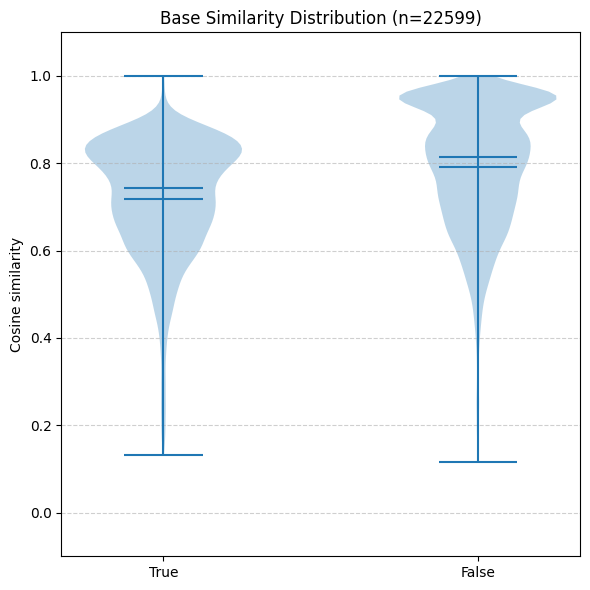

Saved plot to output/hard_fine_tune_model/plots/fine-tuned.png


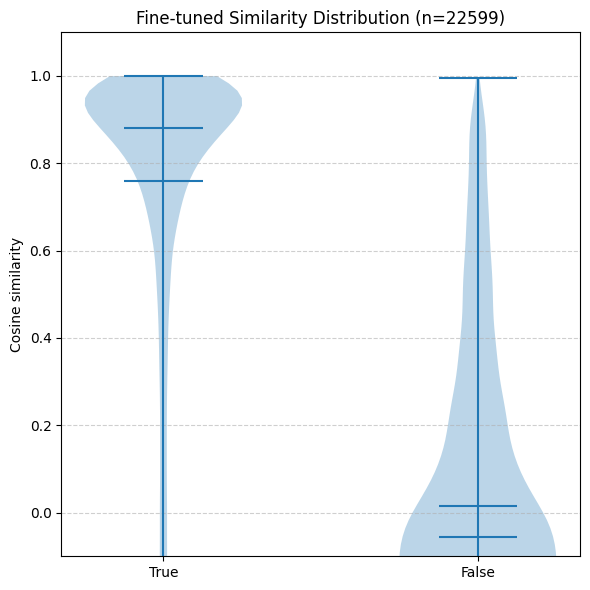

In [9]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, models, util
from huggingface_hub import snapshot_download

with test_jsonl.open("r", encoding="utf-8") as f:
    train_data = [json.loads(line) for line in f]

texts1 = [d['text1'] for d in train_data]
texts2 = [d['text2'] for d in train_data]
labels = np.array([d['label'] for d in train_data])

# Download and cache base model locally
print("Downloading base model to cache...")
base_cache_dir = snapshot_download(repo_id=base_model)
print(f"Base model cached at: {base_cache_dir}")

# Verify that local fine-tuned model directory exists
if not best_model_dir.exists():
    raise FileNotFoundError(f"Fine-tuned model directory not found: {best_model_dir}")
print(f"Using fine-tuned model from: {best_model_dir}")

base_model = load_hf_model(str(base_cache_dir), device=device)
fine_model = load_hf_model(str(best_model_dir), device=device)

def encode_pairs(model, a, b, batch_size=128):
    emb_a = model.encode(a, batch_size=batch_size, convert_to_tensor=True, show_progress_bar=True)
    emb_b = model.encode(b, batch_size=batch_size, convert_to_tensor=True, show_progress_bar=False)
    return emb_a, emb_b

emb_b1, emb_b2 = encode_pairs(base_model, texts1, texts2)
emb_f1, emb_f2 = encode_pairs(fine_model, texts1, texts2)

def get_diag_cosine(a, b):
    return util.cos_sim(a, b).diag().cpu().numpy()

sims = {
    'Base':       get_diag_cosine(emb_b1, emb_b2),
    'Fine-tuned': get_diag_cosine(emb_f1, emb_f2)
}

for name, arr in sims.items():
    true_vals  = arr[labels == 1]
    false_vals = arr[labels == 0]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.violinplot([true_vals, false_vals], showmeans=True, showmedians=True)
    ax.set_title(f"{name} Similarity Distribution (n={len(train_data)})")
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["True", "False"])
    ax.set_ylabel("Cosine similarity")
    ax.grid(True, axis="y", linestyle="--", alpha=0.6)
    ax.set_ylim(-0.1, 1.1)
    plt.tight_layout()

    # Save
    save_path = plot_dir / f"{name.lower().replace(' ', '_')}.png"
    fig.savefig(save_path)

    print(f"Saved plot to {save_path}")
    plt.show()



